# Evaluation of the inferred coupling images to sequences
----

This notebook serves to evaluate the translation performance and thus the quality of the inferred coupling of a trained model to translate between two domains.

---

## 0. Environmental setup

First, we load the required libraries and software packages as well as fix the initialization of the pseudo-random number generators to ensure reproducibility of the analyses.

In [1]:
import sklearn
import numpy as np
import pandas as pd
import torch
import random
import sys

import matplotlib.pyplot as plt

from scipy.stats import pearsonr

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

seed = 1234
random.seed(seed)
np.random.seed(1234)

plt.rcParams["figure.figsize"] = (9,6)

sys.path.append("/home/daniel/PycharmProjects/domain_translation")

from src.data.datasets import TorchNucleiImageDataset
from src.utils.torch.general import get_device
from src.utils.basic.io import get_file_list

In [2]:
def plot_roc_for_stratified_cv(X, y, n_splits, classifier, title):
    cv = StratifiedKFold(n_splits=n_splits)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title=title)
    ax.legend(loc="lower right")
    return fig, ax, classifier

---

## 1. Read in data

Next we read in the data input data and the translated data for a run experiment.

In [69]:
root_dir = "/home/daniel/PycharmProjects/domain_translation/data/cd4/experiments/analyses_of_outlier_vae/"

In [71]:
image_inputs_dir = root_dir + "input_images"
image_labels = pd.read_csv(root_dir + "image_labels.csv", index_col=0)
image_latents = pd.read_csv(root_dir + "image_latents.csv", index_col=0)
translated_pathway_activities = pd.read_csv(
    root_dir + "translated_pathway_activities.csv", index_col=0
)
translated_rna_sequences = pd.read_csv(
    root_dir + "translated_rna_sequences.csv", index_col=0
)
translated_rna_latents = pd.read_csv(root_dir + "translated_rna_latents.csv", index_col=0)

In [72]:
translated_image_dir = root_dir + "translated_images"
rna_inputs = pd.read_csv(root_dir + "rna_inputs.csv", index_col=0)
rna_labels = pd.read_csv(root_dir + "rna_labels.csv", index_col=0)
rna_latents = pd.read_csv(root_dir + "rna_latents.csv", index_col=0)
pathway_activities = pd.read_csv(root_dir + "pathway_activities.csv", index_col=0)
translated_image_latents = pd.read_csv(
    root_dir + "translated_image_latents.csv", index_col=0
)

---

## 2. Validation of the image-to-sequence translation

First, we will quantify how much information is lost by inferring compressing the gene expression profiles into a set of pathway activity scores that is of a much lower dimensionality (339 pathways vs. 5,785 genes). To this end we will train a RandomForrest classifier on the gene expression data and compare the performance using 10-fold stratified cross-validation of the two classifiers.

---

### 2.1. Gene expression classifier

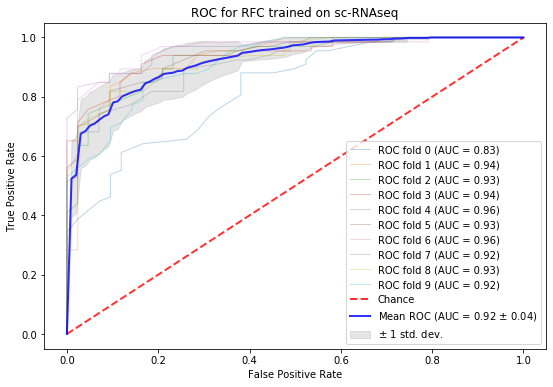

In [73]:
_, _, rna_classifier = plot_roc_for_stratified_cv(
    np.array(rna_inputs),
    np.array(rna_labels).ravel(),
    10,
    RandomForestClassifier(random_state=seed),
    title="ROC for RFC trained on sc-RNAseq"
)

The mean AUC for the RandomForest classifier trained on the gene expression data of the 10-fold stratified cross-validation is 0.92 $\pm$ 0.02.

We will now compare this performance with the one we get when evaluating the trained classifier on gene expression data translated from the images.

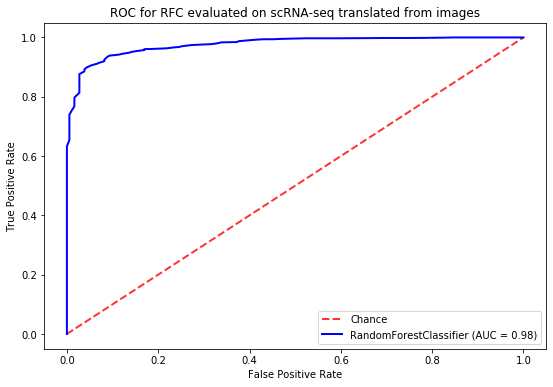

In [74]:
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plot_roc_curve(
    rna_classifier,
    np.array(translated_rna_sequences),
    np.array(image_labels).ravel(),
    lw=2,
    ax=ax,
    color="b",
)
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="ROC for RFC evaluated on scRNA-seq translated from images",
)
ax.legend(loc="lower right")

---

### 2.2. Pathway activity score classifier

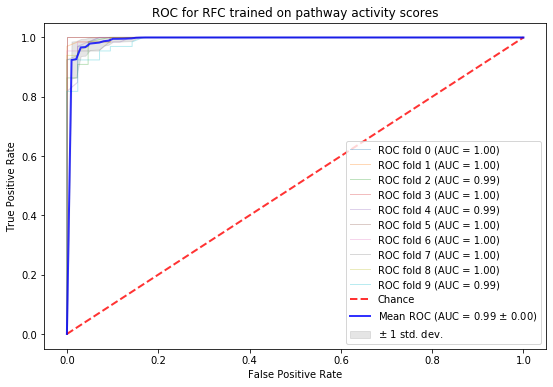

In [75]:
_, _, pas_classifier = fig, ax, classifier = plot_roc_for_stratified_cv(
    np.array(pathway_activities),
    np.array(rna_labels).ravel(),
    10,
    RandomForestClassifier(random_state=seed),
    title="ROC for RFC trained on pathway activity scores"
)

The mean AUC for a similar RandomForest classifier trained on the inferred pathway activity scores to predict whether or not a specific cell is part of the quiescent or poised sub-population of naive CD4+ T cells is 0.97$\pm$0.01.

An explanation for this increased performance compared to the classifier trained on the input gene expression data is that during inferring the parameters to estimate the pathway activity scores the label information were provided already.

---

## 3. Validation of the sequence-to-image translation

Next, we evaluated the performance of the sequence-to-image translation model. To this we will train a RandomForestClassifier on the latent representation obtained by encoding the nuclei images using the trained ImageAE and evaluate this classifier on the latent representation obtained by applying the encoder to the translated images, i.e. the images obtained by encoding the sc-RNAseq data using the PathwayAE, decoding the thereby obtained latent representations using the ImageAE and encoding the translated images again using the encoder of the ImageAE.

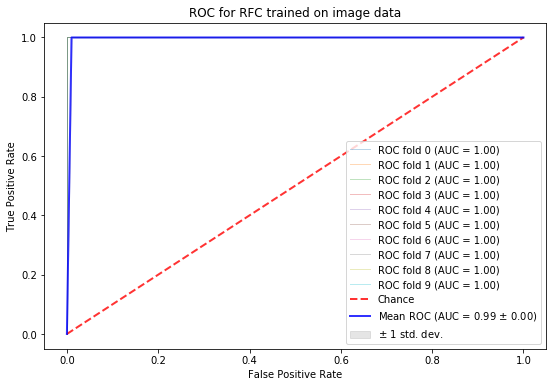

In [76]:
_, _, image_latent_classifier = plot_roc_for_stratified_cv(
    np.array(image_latents),
    np.array(image_labels).ravel(),
    10,
    RandomForestClassifier(random_state=seed),
    title="ROC for RFC trained on image data"
)

The very good performance of the classifier trained on the latent representations obtained after encoding the input images is not surprising as the model was designed to separate the two classes and all label information were already used in the training.

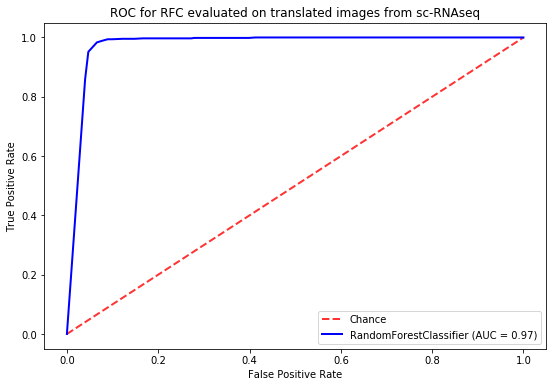

In [77]:
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plot_roc_curve(
    image_latent_classifier,
    np.array(translated_image_latents),
    np.array(rna_labels).ravel(),
    lw=2,
    ax=ax,
    color="b",
)
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="ROC for RFC evaluated on translated images from sc-RNAseq",
)
ax.legend(loc="lower right")

However, we see that when we apply the same classifier on the latent representations obtained from encoding the translated images using the encoder of the ImageAE we still are able to well separate the two classes. Nonetheless, it is important to point out that also here by design the models were trained such that the latent representations are well separabale for both classes. 

---

## 4. Validation of the correlation of the latent representations

Finally, we validate that the latent spaces from the two autoencoders are well mixed by plotting a histogram for the Pearson correlation coefficients for the two latent space representations. If the two spaces would be perfectly aligned we would expect a that all dimensions of the two latent spaces are perfectly correlated and hence the distribution over the Pearson correlation coefficients would be represented by a point mass at 1.



In [78]:
image_zs = np.array(image_latents)
rna_zs = np.array(rna_latents)

In [79]:
rna_pearson_rs = []
for i in range(rna_zs.shape[1]):
    rna_pearson_rs.append(pearsonr(rna_zs[:,i], np.array(translated_image_latents)[:,i])[0])
    

Text(0.5, 1.0, 'Histogram of the Pearson correlation of the rna latent representations')

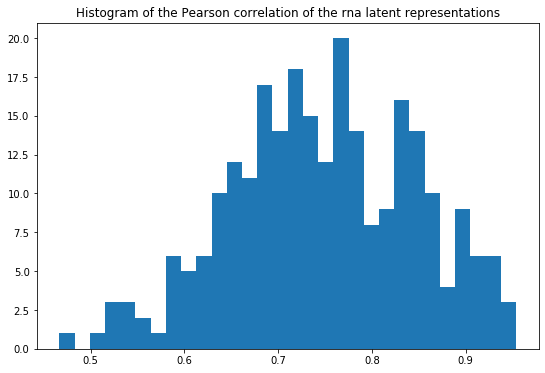

In [83]:
fig = plt.hist(rna_pearson_rs, bins=30)
plt.title("Histogram of the Pearson correlation of the rna latent representations")

We see that for the RNA domain the latent representatitions that we obtain by encoding the sc-RNAseq data using the PathwayAE nicely correlate with the latent representation we obtain when decoding the translated images back to the latent space using the encoder of the ImageAE. The average Pearson correlation coefficient is 0.7675.

In [84]:
image_pearson_rs = []
for i in range(image_zs.shape[1]):
    image_pearson_rs.append(pearsonr(image_zs[:,i], np.array(translated_rna_latents)[:,i])[0])

Text(0.5, 1.0, 'Histogram of the Pearson correlation of the image latent representations')

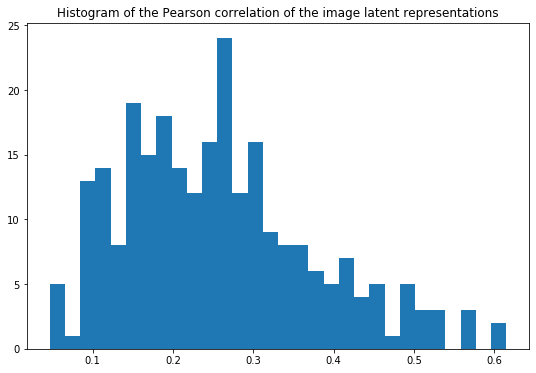

In [85]:
fig = plt.hist(image_pearson_rs, bins=30)
plt.title("Histogram of the Pearson correlation of the image latent representations")

This does not hold for the image domain, where we the latent representations we obtain by encoding the images using the ImageAE are mostly uncorrelated to the ones that we obtain when translating the images to sc-RNAseq data and encoding this data using the PathwayAE.

When looking at the distribution of the means of the individual latent dimensions of these two vector we immediately see that also the scale of the latent representation vectors are very different for the two.

However, it is not guaranteed that this implies cycle inconsistencies as the highly-nonlinear decoder of the ImageAE might still be able to reconstruct an image from the very different latent representation obtained by cycling between the domains that is very similar to the input image. Note that the Pearson correlation coefficient is only a measure for linear correlation.

Future work should systemically assess this and if thereby cycle inconsistencies are detected - adding a respective loss might substantially improve the translation performance and thus first enable the drawing of conclusions from perturbation experiments or similar assessments.